In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize

In [40]:
import sys
import os

In [41]:
sys.path.append(os.path.abspath('../scripts'))

In [42]:
from analysis_and_modeling import *

In [5]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [6]:
data = fetch_data(tickers, start_date, end_date)

[*********************100%***********************]  3 of 3 completed


In [7]:
cleaned_data, missing_values = sanitize_data(data)
print("Missing Values:\n", missing_values)

Missing Values:
 Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\scripts\analysis_and_modeling.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.interpolate(method='linear').fillna(method='bfill')
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\scripts\analysis_and_modeling.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill').fillna(method='ffill')


In [8]:
summary_stats = summarize_data(cleaned_data)
summary_stats

Ticker,BND,SPY,TSLA
count,2474.000000,2474.000000,2474.000000
mean,70.089252,310.253153,111.438965
std,4.889919,111.250656,110.120450
min,62.637600,157.328568,9.578000
25%,66.314068,214.822342,17.066167
50%,68.888935,275.812332,25.043000
75%,73.807495,402.297508,216.865002
max,79.812935,584.590027,409.970001


In [9]:
normalized_data = standardize_data(cleaned_data)

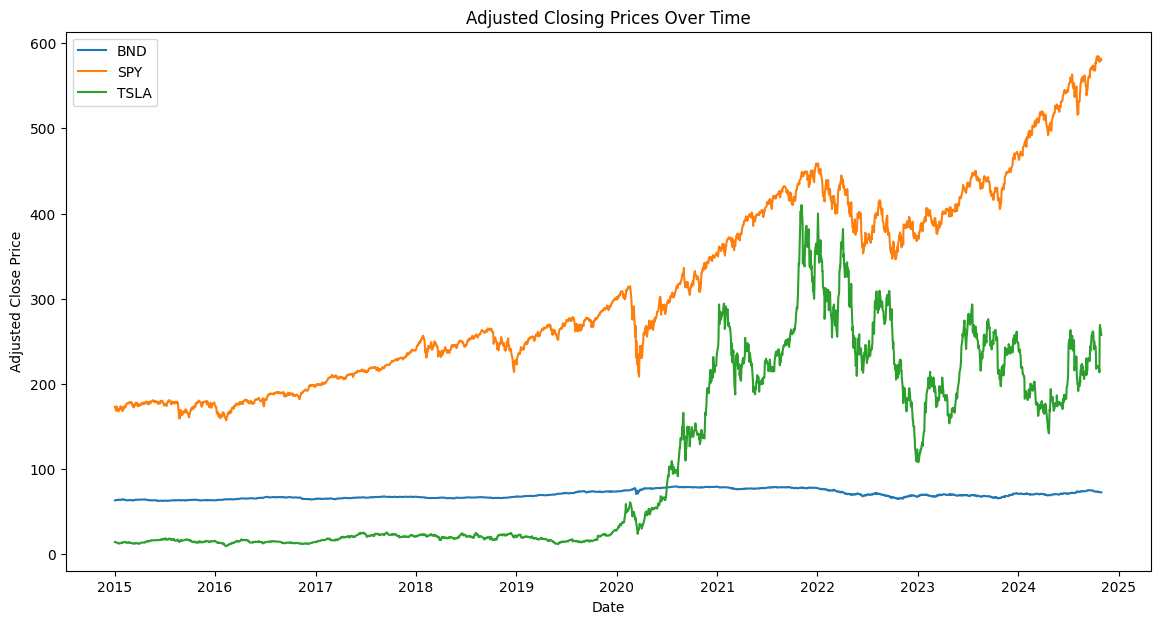

In [10]:
visualize_closing_prices(cleaned_data)

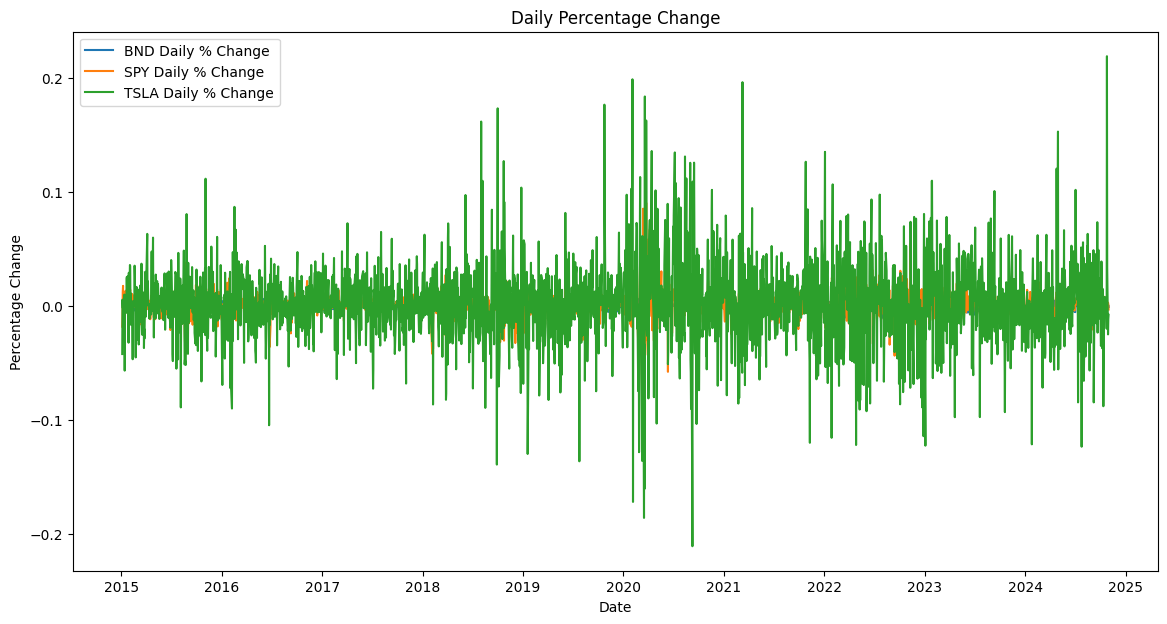

In [11]:
pct_change = visualize_daily_percentage_change(cleaned_data)

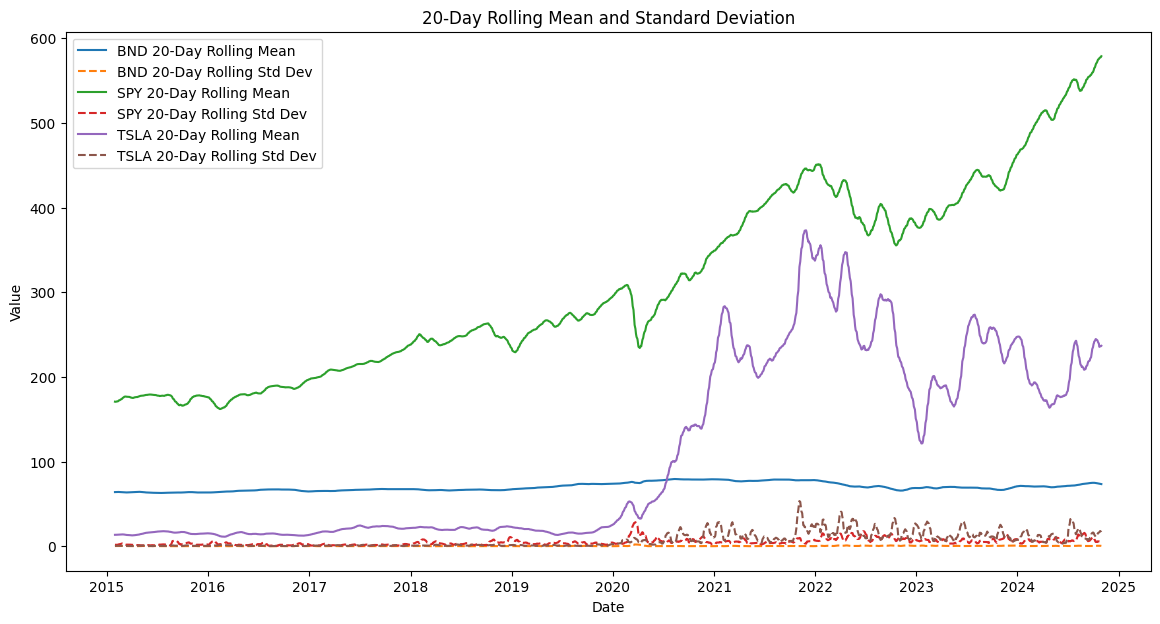

In [12]:
visualize_rolling_statistics(cleaned_data, window_size=20)

In [13]:
outliers = identify_outliers(pct_change)
outliers

,BND,SPY,TSLA
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2468,NaN,NaN,0.21919
2469,NaN,NaN,NaN
2470,NaN,NaN,NaN
2471,NaN,NaN,NaN


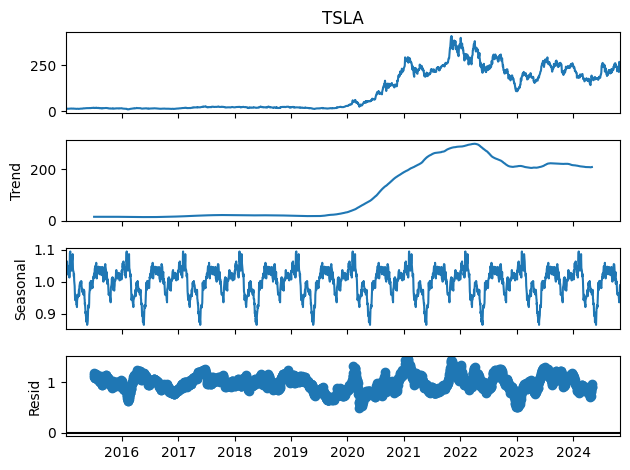

In [14]:
decomposition = decompose_time_series(cleaned_data, 'TSLA')

In [15]:
val_risk, ratio = compute_risk_metrics(cleaned_data)

In [16]:
print(val_risk)
ratio

Ticker
BND    -0.004798
SPY    -0.016764
TSLA   -0.051257
Name: 0.05, dtype: float64


Ticker
BND    -0.004994
SPY     0.042373
TSLA    0.048033
dtype: float64

In [17]:
cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_5872\624246787.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')


In [18]:
cleaned_data.to_csv('../Data/cleaned_data.csv', index=True)

In [19]:
cleaned_data.head()

Ticker,BND,SPY,TSLA
Date,,,
2015-01-02 00:00:00+00:00,63.358761,173.173798,14.620667
2015-01-05 00:00:00+00:00,63.542736,170.046310,14.006000
2015-01-06 00:00:00+00:00,63.726738,168.444687,14.085333
2015-01-07 00:00:00+00:00,63.765057,170.543625,14.063333
2015-01-08 00:00:00+00:00,63.665409,173.569977,14.041333
